In [ ]:
# default_exp sparse.schedule

# Schedules

> When should I prune my network ?

In [ ]:
#export
import numpy as np
import matplotlib.pyplot as plt
from fastcore.basics import *
from fastai.callback.schedule import *

In [ ]:
#hide
from fastai.vision.all import *

In [ ]:
#export
class Schedule():
    def __init__(self, sched_func, start_pct=0., end_pct=None, start_sparsity=0.):
        store_attr()
        self.current_sparsity, self.previous_sparsity = map(listify, [start_sparsity, start_sparsity])
        if self.end_pct is None: self.end_pct=1.
        
    def __call__(self, end_sparsity, pct_train):
        if type(end_sparsity)!= 'list': end_sparsity = listify(end_sparsity)
        if pct_train>=self.start_pct and pct_train <= self.end_pct: 
            self.current_sparsity = [self.sched_func(self.start_sparsity, sp, (pct_train-self.start_pct)/(self.end_pct-self.start_pct)) for sp in end_sparsity]
        return self.current_sparsity
        
    @property
    def pruned(self):
        return self.previous_sparsity!=self.current_sparsity
    
    def after_pruned(self):
        self.previous_sparsity=self.current_sparsity
    
    def plot(self, end_sparsity):
        prune = np.linspace(0, 1, 1000)
        sps = [self([end_sparsity], p) for p in prune]
        fig, ax = plt.subplots(1, 1, figsize=(8,6), dpi=100)
        plt.plot(prune, sps, c='teal', linewidth=2)
        plt.xlabel('training iterations (Normalized)')
        plt.ylabel('sparsity')
        self.current_sparsity = self.previous_sparsity
    
    def reset(self):
        self.current_sparsity, self.previous_sparsity = map(listify, [self.start_sparsity, self.start_sparsity])

## One-Shot

The easiest schedule is the one-shot pruning, i.e. prune the network once. This can be done by simply returning the desired sparsity value. The moment when you want to prune will be controlled by the `start_epoch` argument in the `SparsifyCallback`.

In [ ]:
#export
def sched_oneshot(start, end, pos): return end

one_shot = Schedule(sched_oneshot, start_pct=0.5)

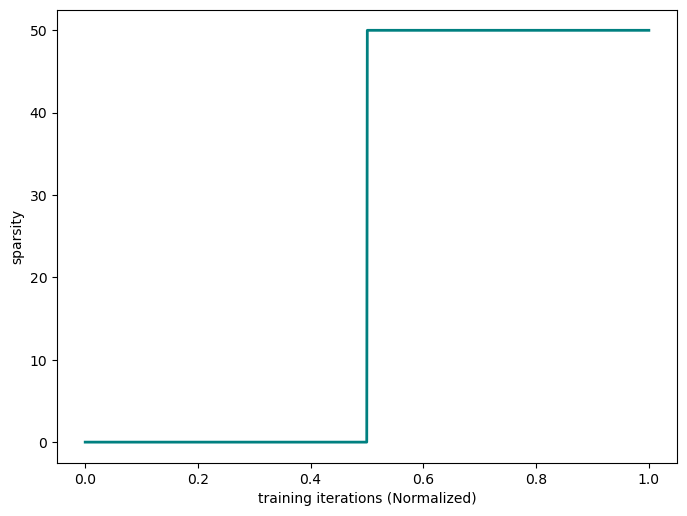

In [ ]:
one_shot.plot(50)

---

## Iterative

Instead of pruning the network to desired sparsity in one step, you can do it iteratively. In fasterai, you can change the amount of iterations

In [ ]:
#export
def sched_iterative(start, end, pos, n_steps=3):
    "Perform iterative pruning, and pruning in `n_steps` steps"
    return start + ((end-start)/n_steps)*(np.ceil((pos)*n_steps))

iterative = Schedule(sched_iterative, start_pct=0.2)

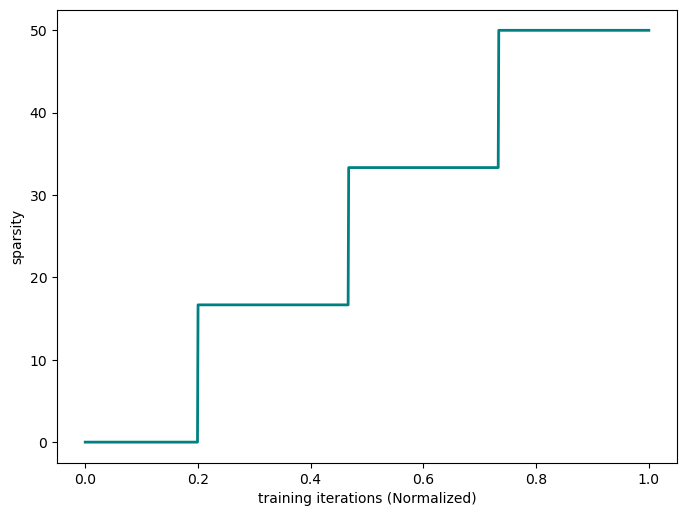

In [ ]:
iterative.plot(50)

To modify the default `n_steps`, you can use the `partial` function.

In [ ]:
iterative = Schedule(partial(sched_iterative, n_steps=5), start_pct=0.2)

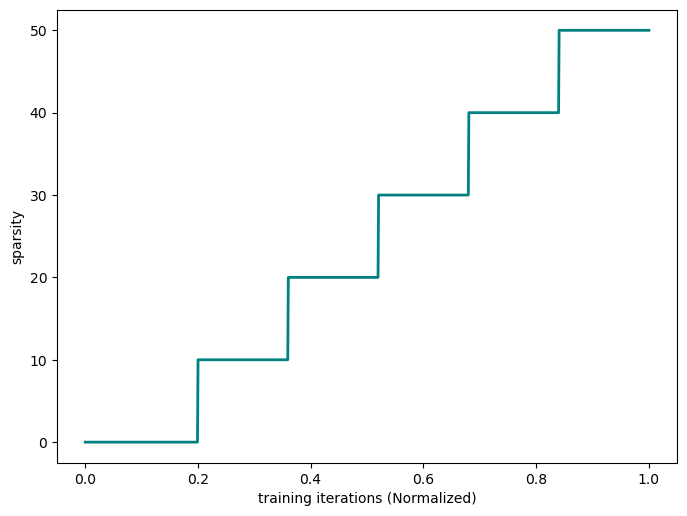

In [ ]:
iterative.plot(50)

---

## Automated Gradual Pruning

Some researchers have come up with more sophisticated schedules, such as the [Automated Gradual Pruning](https://arxiv.org/abs/1710.01878).

In [ ]:
#export
def sched_agp(start, end, pos): return end + (start - end) * (1 - pos)**3

agp = Schedule(sched_agp, start_pct=0.2)

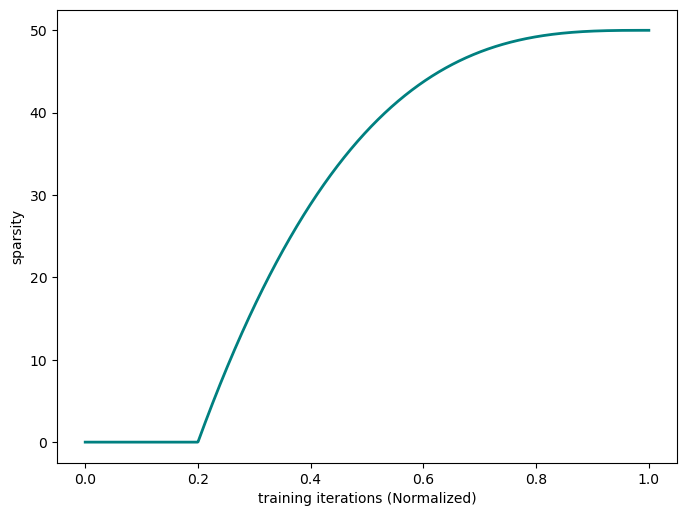

In [ ]:
agp.plot(50)

## One-Cycle Pruning

In [ ]:
#export
def sched_onecycle(start, end, pos, α=14, β=6):
    out = (1+np.exp(-α+β)) / (1 + (np.exp((-α*pos)+β)))
    return start + (end-start)*out

one_cycle = Schedule(sched_onecycle)

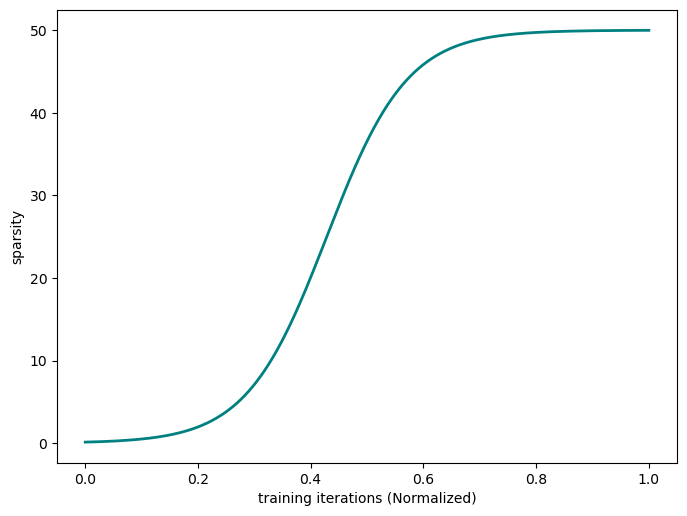

In [ ]:
one_cycle.plot(50)

On top of that, all of the schedules available in fastai by default are also available:
- sched_cos
- sched_linear

In [ ]:
#export
cos = Schedule(sched_cos)
lin = Schedule(sched_lin)

---

## Dense-Sparse-Dense

You can also create even more interesting behaviours such as the DSD method, where you prune the model in the first place, then re-grow it to its initial amount of parameter.

In [ ]:
#export
def sched_dsd(start, end, pos):
    if pos<0.5:
        return start + (1 + math.cos(math.pi*(1-pos*2))) * (end-start) / 2
    else:
        return end + (1 - math.cos(math.pi*(1-pos*2))) * (start-end) / 2
    
dsd = Schedule(sched_dsd)

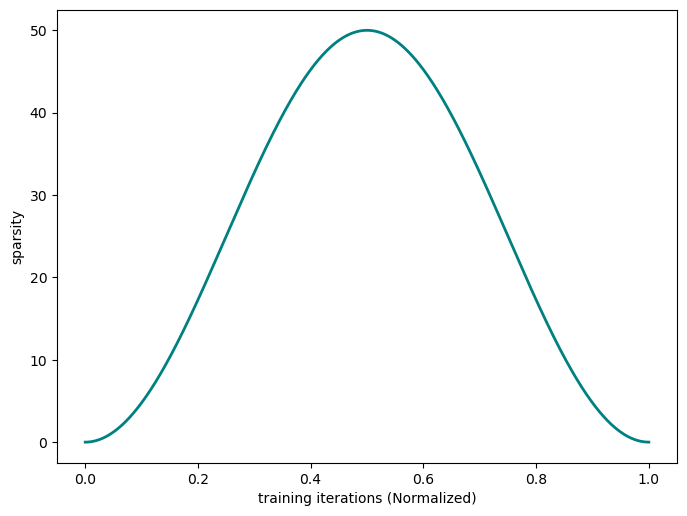

In [ ]:
dsd.plot(50)

In [ ]:
#export
schedules = ('one_shot', 'iterative', 'one_cycle', 'cos', 'lin', 'dsd')
def available_schedules():
    print(schedules)